In [1]:
# Imports
import sys
import os
import numpy as np
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.Material import unitDensityMaterial
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import DiffusionTestParticle
from electronTransportCode.SimOptions import DiffusionPointSource
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
%matplotlib widget


In [2]:
# Initialize Advection-Diffusion parameters (No advection)
StoppingPower = 1
scatteringRate1 = 50
scatteringRate2 = 500
varH = 1  # 1 in 1D, 1/3 in 3D
sigmaInit = 1.0
muInit = 0.0

# Initialize simulation parameters
tmax = 1.0
xbins = 512
xmax = 15.0

# initialize the equation and the space
# eq = PDE({"φ": f"{var} * φ * d_dx(φ) - laplace(d_dx(φ))"})
eq1 = PDE({"φ": f"laplace({varH}*φ/({StoppingPower}*{scatteringRate1}))"})
eq2 = PDE({"φ": f"laplace({varH}*φ/({StoppingPower}*{scatteringRate2}))"})
grid = CartesianGrid([(-xmax, xmax)], [xbins], periodic=True)
state = ScalarField.from_expression(grid, f"exp(-0.5*((x-{muInit})/{sigmaInit})**2)/({sigmaInit}*sqrt(2*{np.pi}))")

# solve the equation and store the trajectory
storage1 = MemoryStorage()
result1 = eq1.solve(state, t_range=tmax, tracker=storage1.tracker(1), dt=1e-5)

storage2 = MemoryStorage()
result2 = eq2.solve(state, t_range=tmax, tracker=storage2.tracker(1), dt=1e-5)

In [3]:
# Initialize Monte Carlo Algorithm

# Set up simulation domain
ymin = -xmax; ymax = xmax; ybins = 2
zmin = -xmax; zmax = xmax; zbins = 2
simDomain = SimulationDomain(ymin, ymax, zmin, zmax, ybins, zbins, material=unitDensityMaterial)

# Set up initial conditions
NB_PARTICLES = 30000
eSource: float = tmax
SEED: int = 4  # Random number generator seed
pointSourceSim = DiffusionPointSource(minEnergy=0.0, rngSeed=SEED, eSource=eSource, loc=muInit, std=sigmaInit)

# Set up estimator and particle
trackEndEstimatorx1 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')
trackEndEstimatorx2 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')

particle1 = DiffusionTestParticle(Es=scatteringRate1)
particle2 = DiffusionTestParticle(Es=scatteringRate2)

particleTracer1 = AnalogParticleTracer(particle=particle1, simOptions=pointSourceSim, simDomain=simDomain)
particleTracer2 = AnalogParticleTracer(particle=particle2, simOptions=pointSourceSim, simDomain=simDomain)

# Run simulation
particleTracer1(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx1))
particleTracer2(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx2))


Last 1000 particles took 13.82705045900002 seconds. 3.3333333333333335% completed.
Last 1000 particles took 11.469612048998897 seconds. 6.666666666666667% completed.
Last 1000 particles took 10.83691013600037 seconds. 10.0% completed.
Last 1000 particles took 11.955780987000253 seconds. 13.333333333333334% completed.
Last 1000 particles took 12.249030498998764 seconds. 16.666666666666668% completed.
Last 1000 particles took 13.492743769998924 seconds. 20.0% completed.
Last 1000 particles took 11.191255629999432 seconds. 23.333333333333332% completed.
Last 1000 particles took 11.563970948998758 seconds. 26.666666666666668% completed.
Last 1000 particles took 11.104191071000969 seconds. 30.0% completed.
Last 1000 particles took 11.340935637999792 seconds. 33.333333333333336% completed.
Last 1000 particles took 11.736661089000336 seconds. 36.666666666666664% completed.
Last 1000 particles took 11.065743908000513 seconds. 40.0% completed.
Last 1000 particles took 11.186834553000153 seconds

KeyboardInterrupt: 

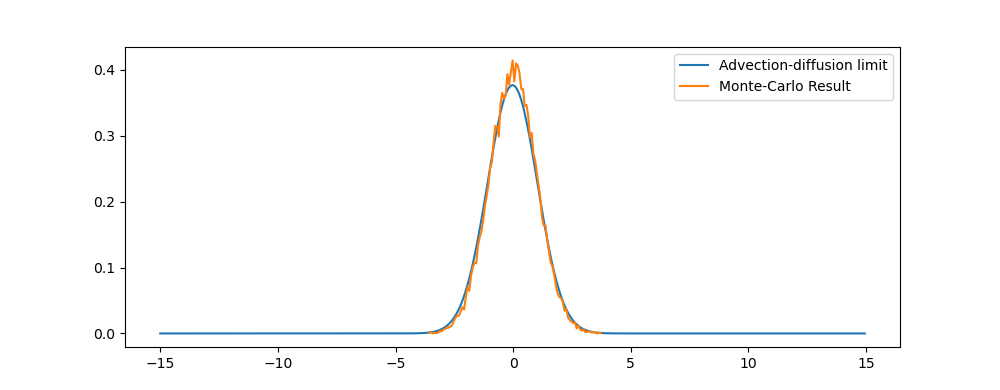

In [ ]:
# Plot solutions

# Advection-diffusion solution
ADres = storage.data[-1]
xres = np.linspace(-xmax, xmax, xbins, endpoint=False)

# MC solution
xdensity = trackEndEstimatorx.scoreMatrix
binVal, binEdge = np.histogram(xdensity, bins=100, density=True)
binCenter = (binEdge[:-1] + binEdge[1:])/2.0

fix, ax = plt.subplots(figsize=(10, 3.9))
ax.plot(xres, ADres, '-', label='Advection-diffusion limit')
ax.plot(binCenter, binVal, label='Monte-Carlo Result')
ax.legend()